In [ ]:
#RNN下的姓名分类（按照其语言类型分类）

In [31]:

import torch

# 选择cpu or gpu
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [33]:
import string
import unicodedata

# 使用_来代替未在字典中出现的字符
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# 奖Unicode编码转为ASCII编码 
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [37]:
#获取字符的序号
def letterToIndex(letter):
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)
#将输入字符转化为tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letterToIndex(letter)] = 1
    return tensor

In [39]:
from io import open
import glob
import os
import time

import torch
from torch.utils.data import Dataset

In [41]:
class NamesDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir # 保存数据目录路径（用于记录数据来源）
        self.load_time = time.localtime() # 保存加载时间（用于记录数据来源）
        
        # 只存储文件路径和每个文件对应的标签，不加载内容，防止内容过载
        self.samples = []  # 存储 (name, label) 的元组
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            # 逐行读取，但只保存 (name, label)，不保存张量！
            with open(filename, encoding='utf-8') as f:
                for line in f:
                    name = line.strip()
                    if name:  # 忽略空行
                        self.samples.append((name, label))
        
        # 构建标签到索引的映射（只需一次）
        unique_labels = sorted(set(label for _, label in self.samples))
        self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        self.idx_to_label = unique_labels  # 可选：用于反向查找

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        name, label = self.samples[idx]
        # 在这里才转换为张量
        data_tensor = lineToTensor(name)  # 按需计算
        label_tensor = torch.tensor([self.label_to_idx[label]], dtype=torch.long)
        return label_tensor, data_tensor, label, name

In [43]:
alldata = NamesDataset("data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([0], device='cuda:0'), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0.,

In [45]:
#将数据分为训练集和测试集
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


In [47]:
import torch.nn as nn
import torch.nn.functional as F
#创建RNN网络
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        #最基础的RNN设置
        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [54]:
n_hidden = 128
n_categories = len(alldata.label_to_idx) 
rnn = CharRNN(n_letters, n_hidden, n_categories)
print(rnn)

CharRNN(
  (rnn): RNN(58, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [50]:
import random
import numpy as np

def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # 清空梯度

        # 创建一些小的batch
        # 不能使用torch的dataLoader因为字符串长度不同
        batches = list(range(len(training_data)))
        random.shuffle(batches)

        
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #在一个batch中的每一个数据
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # 优化器设置
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [52]:
#进行训练
start = time.time()
all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)
end = time.time()
print(f"training took {end-start}s")

training on data set with n = 17063
5 (19%): 	 average batch loss = 0.6472213405096648
10 (37%): 	 average batch loss = 0.5199826579612069
15 (56%): 	 average batch loss = 0.4463726895161624
20 (74%): 	 average batch loss = 0.4086483180764233
25 (93%): 	 average batch loss = 0.37869993229867954
training took 806.0718743801117s


In [66]:
def predict(name, rnn, dataset):
    rnn.eval()  # 切换到评估模式
    with torch.no_grad():
        input_tensor = lineToTensor(name)  # shape: (L, 1, n_letters)
        output = rnn(input_tensor)         # shape: (1, num_classes)
        top_i = output.argmax().item()     # 直接取最大值索引
        return dataset.idx_to_label[top_i]

print(predict("John", rnn, alldata))

Scottish


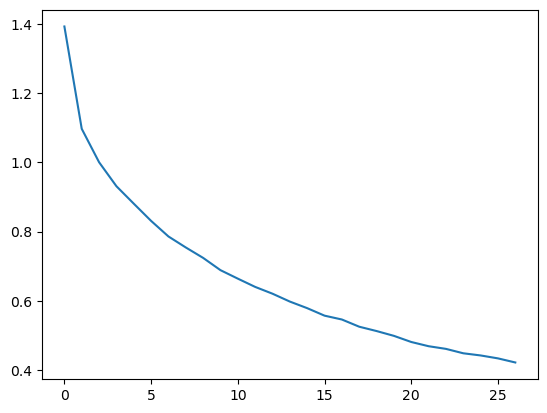

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#绘制损失曲线
plt.figure()
plt.plot(all_losses)
plt.show()

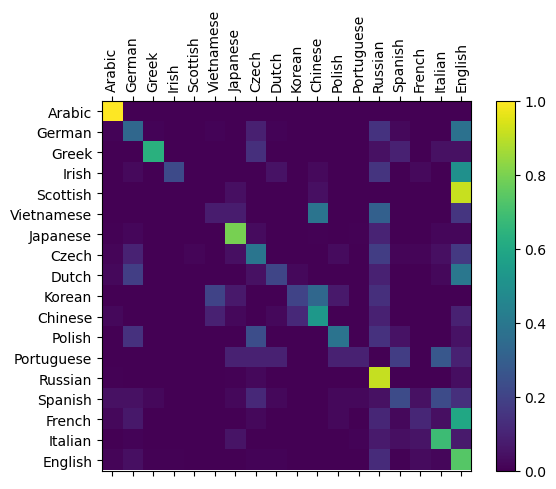

In [29]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #将模型设置为评估模式
    with torch.no_grad(): # 不记录张量的梯度
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # 评估每一个类别
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # 绘画相关的图片
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy的使用需要用到cpu
    fig.colorbar(cax)

    # 设置axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)


    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    
    plt.show()



evaluate(rnn, test_set, classes=alldata.labels_uniq)